# COVID-19 Segmentation 

Referencia de Notebook Utilizado: https://www.kaggle.com/code/oskaradolfovillalpez/covid-segmentation/notebook

Voto positivo: 

![Voto](/recursos/upvote.png "Voto")

Etica:

Los datos son anonimos para mantener la confidencialidad.

## 1. Introducción

### Descripción del Problema

En el diagnostico de pacientes con COVID-19, una de las herramientas más comunes es la tomografía computarizada. Las imágenes obtenidas por CT permiten a los radiólogos observar detalladamente el estado de los pulmones y detectar signos de daño, como las áreas afectadas por infecciones virales. Sin embargo, analizar manualmente cada imagen de tomografía para segmentar las áreas afectadas es una tarea intensiva y que consume mucho tiempo. Estas áreas afectadas son indicadores clave de la gravedad de la enfermedad y de la extensión del daño pulmonar. 

Dada a la pandemia de COVID-19 ha aumentado significativamente la carga de trabajo de los radiólogos, la necesidad de soluciones automatizadas para acelerar y mejorar el proceso de diagnóstico ha cobrado una gran importancia. El principal problema que se aborda en este desafío es la automatización del proceso de segmentación de estas lesiones en los pulmones de pacientes con COVID-19, con el objetivo de mejorar la precisión y reducir el tiempo necesario para obtener un diagnostico.

### Objetivos de la Competencia en Kaggle

La competencia de Kaggle tiene como objetivo desarrollar modelos de segmentación automática que pueden identificar y delimitar las áreas de “vidrio esmerilado” y “consolidación” en las imágenes de CT de los pulmones de los pacientes.

#### Vidrio esmerilado:

El término “vidrio esmerilado” hace referencia a una opacidad en los pulmones que aparece en las imágenes de CT. Estas areas indican una mayor densidad dentro de los pulmones, lo que significa que algo esta llenando parcialmente los espacios de aire dentro de los pulmones. Esto puede representar inflamación pulmonar causada por la infección.

#### Consolidación:

La consolidación se refiere a una afección en la que los espacios llenos de aire en los alvéolos pulmonares son reemplazados por liquido, pus, sangre u otras sustancias.

#### Diferencias:

- Densidad: El vidrio esmerilado es menos denso que la consolidación.
- Gravedad: El vidria suele aparecer en fases iniciales o menos grave  a comparación de consolidación que tiende a presentarse en fases mas avanzadas.

### Importancia de la segmentación en imágenes medicas:

1. Precisión y Velocidad: La segmentación automática de las imágenes CT permitirá a los radiólogos obtener una evaluación más rápida y precisa del daño pulmonar. 
2. Diagnóstico Estandarizado: Los sistemas automatizados basados en IA pueden ayudar a estandarizar el proceso de diagnóstico, eliminando la variabilidad entre diferentes radiólogos y mejorando la consistencia de los resultados.

## 2. Análisis de Datos:

Importamos las siguientes librerias:
- numpy: Manejo eficiente de arreglos y operaciones matemáticas avanzadas
- pandas: Facilita el trabajo con estructuras de datos
- matplotlib: Nos sirve para generar graficos
- os: Proporciona funciones para interactuar con el sistema operativo, como acceder a archivos y directorios. 

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [143]:
for dirname, _, filenames in os.walk("data/covid-segmentation"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/covid-segmentation/images_medseg.npy
data/covid-segmentation/images_radiopedia.npy
data/covid-segmentation/masks_medseg.npy
data/covid-segmentation/masks_radiopedia.npy
data/covid-segmentation/test_images_medseg.npy


In [144]:
prefix = "data/covid-segmentation/"

### Descripción del Conjunto de Datos (EDA)

Las imágenes de tomografía computarizada (CT) provienen de dos conjuntos de datos: Radiopedia y MedSeg.

El conjunto de datos consiste en:
- images_radiopedia: Imágenes CT de Radiopedia.
- masks_radiopedia: Máscaras de segmentación para las imágenes de Radiopedia.
- images_medseg: Imágenes CT de MedSeg.
- masks_medseg: Máscaras de segmentación para las imágenes de MedSeg.
- test_images_medseg: Imágenes de prueba de MedSeg (sin máscara asociada).

In [145]:
images_radiopedia = np.load(os.path.join(prefix, "images_radiopedia.npy")).astype(
    np.float32
)
masks_radiopedia = np.load(os.path.join(prefix, "masks_radiopedia.npy")).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, "images_medseg.npy")).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, "masks_medseg.npy")).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, "test_images_medseg.npy")).astype(
    np.float32
)

In [ ]:
print(images_radiopedia.shape)
print(masks_radiopedia.shape)
print(images_medseg.shape)
print(masks_medseg.shape)
print(test_images_medseg.shape)

## Visualization


Este código genera una visualización donde puedes observar las imágenes

In [146]:
def visualize(
    image_batch: np.ndarray,
    mask_batch: np.ndarray = None,
    pred_batch: np.ndarray = None,
    num_samples: int = 8,
    hot_encode: bool = True,
) -> None:
    """
    Plots the images, masks and predictions of a batch of samples

    Args:
      image_batch (np.ndarray): batch of images to visualize
      mask_batch (np.ndarray): batch of masks to visualize
      pred_batch (np.ndarray): batch of predictions to visualize
      num_samples (int): number of samples to visualize
      hot_encode (bool): whether to hot encode the masks and predictions
    """

    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fig, ax = plt.subplots(
        num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2)
    )

    for index in range(num_samples):
        ax_image = ax[0, index] if num_classes > 0 else ax[index]

        if hot_encode:
            ax_image.imshow(image_batch[index, :, :, 0], cmap="Greys")

        else:
            ax_image.imshow(image_batch[index, :, :], cmap="bone")

        ax_image.set_xticks([])
        ax_image.set_yticks([])

        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[index, :, :, j]

                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))
                    mask_to_show[..., 0] = pred_batch[index, :, :, j] > 0.5
                    mask_to_show[..., 1] = mask_batch[index, :, :, j]

                ax[j + 1, index].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, index].set_xticks([])
                ax[j + 1, index].set_yticks([])

    plt.tight_layout()
    plt.show()

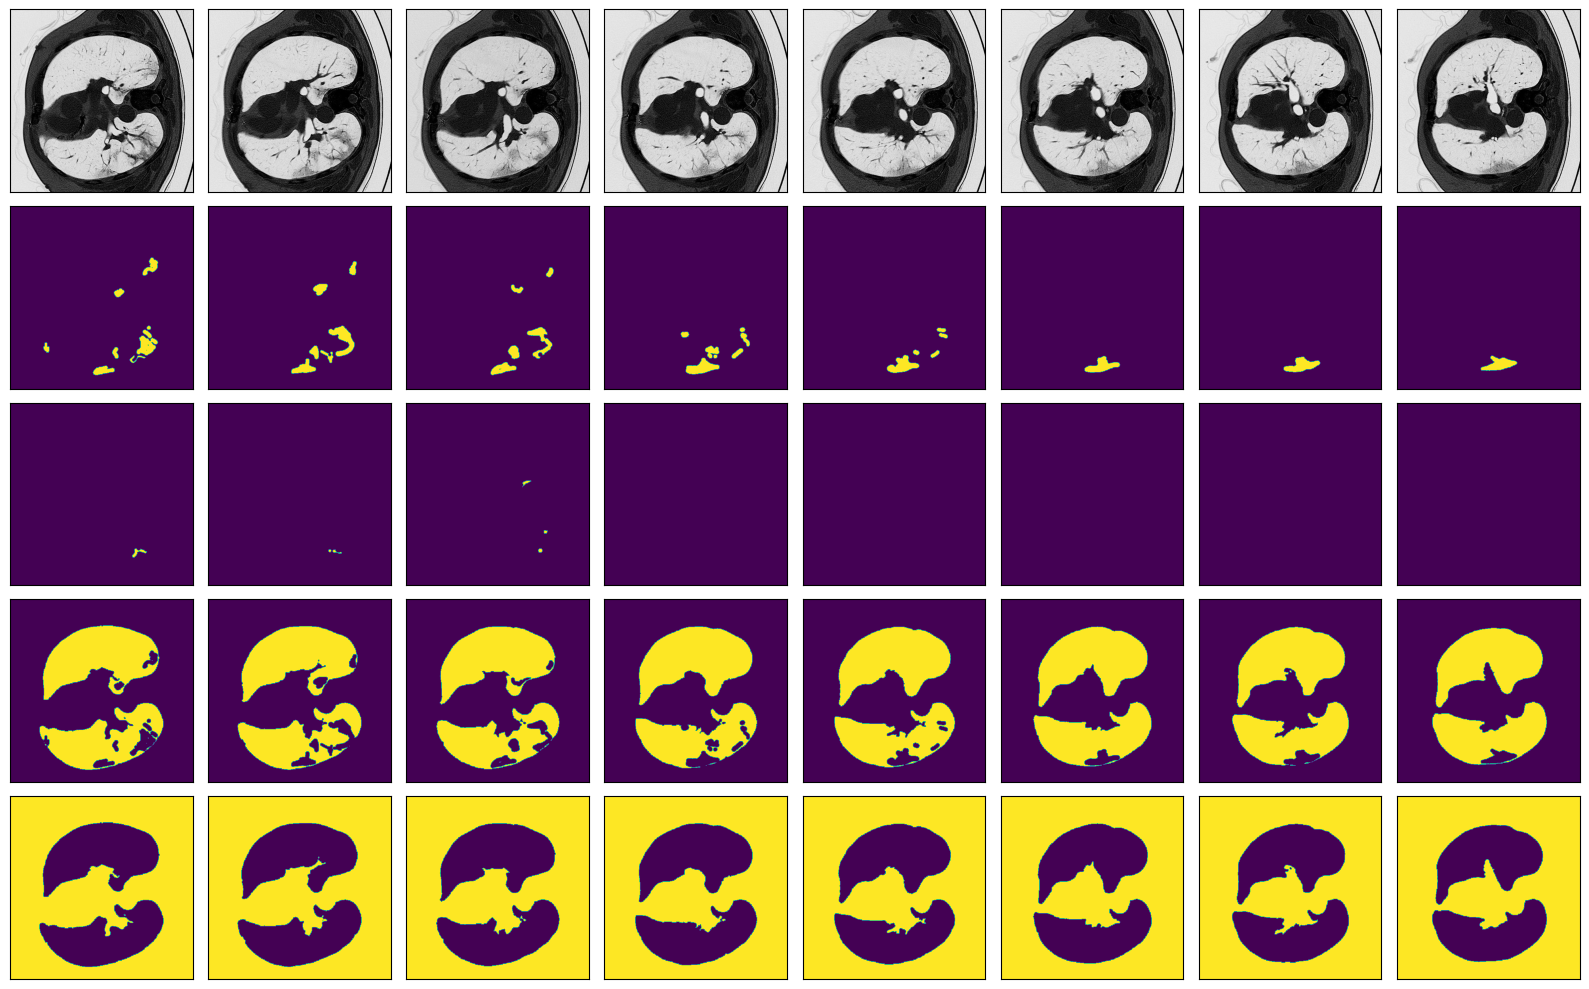

In [147]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

Utilizamos one hot ya que es importante que cada clase tenga su propio canal en lugar de usar un solo valor por píxel. Esto facilita que el modelo entienda qué partes de la imagen corresponden a cada clase. Las clases son:

0: Vidrio esmerilado ("ground glass").
1: Consolidación ("consolidations").
2: Otras partes de los pulmones ("lungs other").
3: Fondo ("background").

In [148]:
def onehot_mask(mask: np.ndarray, palette: list) -> np.ndarray:
    """
    Converts a mask (H, W, K) to one-hot encoded format (H, W, C).

    Args:
      mask (np.ndarray): mask to convert to one-hot encoded format
      palette (List[List[int]]): list of colours to use for the conversion

    Returns:
      np.ndarray: one-hot encoded mask
    """

    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette, dtype=np.uint8)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

In [149]:
palette = [[0], [1], [2], [3]]

In [150]:
masks_radiopedia_recover = onehot_mask(masks_radiopedia, palette).squeeze()

In [151]:
masks_medseg_recover = onehot_mask(masks_medseg, palette).squeeze()

In [152]:
print(f"Hot encoded mask size: {masks_radiopedia.shape}")
print(f"Hot encoded mask size: {masks_medseg_recover.shape}")

Hot encoded mask size: (829, 512, 512, 4)
Hot encoded mask size: (100, 512, 512)


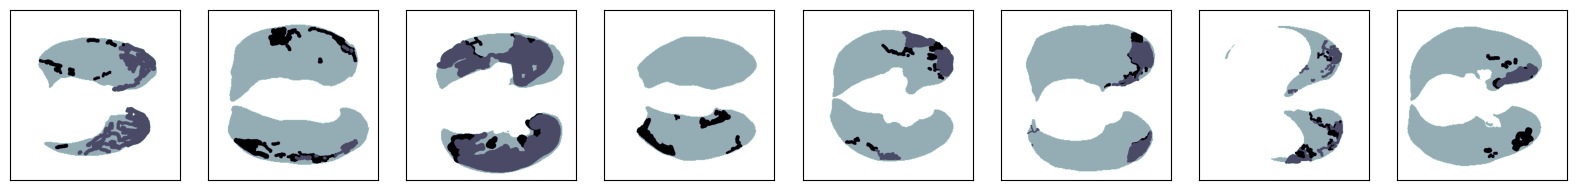

In [153]:
visualize(masks_medseg_recover[30:], hot_encode=False)

## Preprocess image


- Para las imágenes de CT, se aplicó un recorte a los valores de los píxeles, restringiéndolos entre -1500 y 500. Esto ayuda a eliminar ruido y valores irrelevantes que no corresponden a las áreas de interés en los pulmones.

- Se normalizaron los valores de los píxeles para tener una distribución con media 0 y desviación estándar 1, lo que ayuda a los modelos de aprendizaje automático a entrenarse de manera más efectiva.

In [154]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500

    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)

    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]

    mean, std = (
        (images_arr_valid.mean(), images_arr_valid.std())
        if mean_std is None
        else mean_std
    )

    images_arr = (images_arr - mean) / std
    print(f"mean {mean}, std {std}")
    return images_arr, (mean, std)

In [155]:
images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


Graficamos un histograma de valores de píxeles, que muestra la distribución de intensidades en las imágenes.

In [156]:
def plot_hists(
    images1, images2=None, label1: str = "Images 1", label2: str = "Images 2"
):
    fig, ax = plt.subplots(figsize=(10, 6))

    all_data = (
        np.concatenate([images1.ravel(), images2.ravel()])
        if images2 is not None
        else images1.ravel()
    )
    min_val, max_val = np.min(all_data), np.max(all_data)

    bins = np.linspace(min_val, max_val, 100)

    ax.hist(
        images1.ravel(),
        bins=bins,
        density=True,
        color="b",
        alpha=1 if images2 is None else 0.5,
        label=label1,
    )

    if images2 is not None:
        ax.hist(
            images2.ravel(),
            bins=bins,
            density=True,
            alpha=0.5,
            color="orange",
            label=label2,
        )

    ax.set_xlim(min_val, max_val)
    ax.set_xticks(np.linspace(min_val, max_val, 5))
    ax.set_xticklabels([f"{x:.1f}" for x in ax.get_xticks()])

    ax.set_ylim(bottom=0)
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 8))
    ax.set_yticklabels([f"{y:.1f}" for y in ax.get_yticks()])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xlabel("Pixel Value")
    plt.ylabel("Density")
    plt.title("Pixel Value Distribution")

    plt.legend()
    plt.tight_layout()
    plt.show()

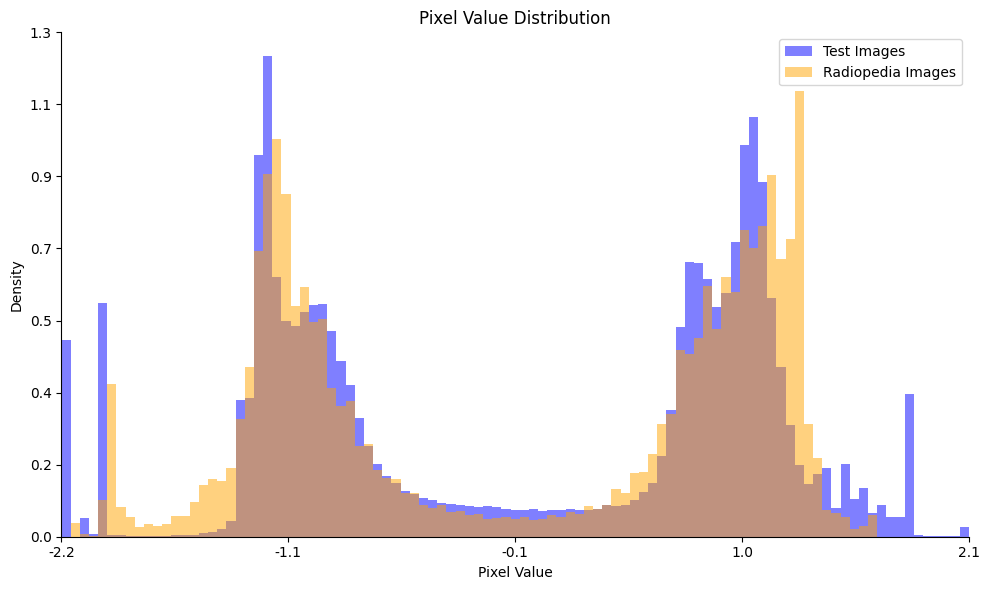

In [157]:
plot_hists(test_images_medseg, images_radiopedia, "Test Images", "Radiopedia Images")

## Split train & validation


In [158]:
masks_radiopedia_recover = onehot_mask(masks_radiopedia, palette).squeeze()
masks_medseg_recover = onehot_mask(masks_medseg, palette).squeeze()

In [159]:
val_index, train_index = list(range(24)), list(range(24, 100))

In [160]:
train_images = np.concatenate([images_medseg[train_index], images_radiopedia])
train_masks = np.concatenate(
    (masks_medseg_recover[train_index], masks_radiopedia_recover)
)

In [161]:
val_images = images_medseg[val_index]
val_masks = masks_medseg_recover[val_index]

In [162]:
batch_size = len(val_masks)

In [163]:
del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

## Data Augmnentation


In [164]:
import tensorflow
import albumentations
import cv2

In [165]:
SOURCE_SIZE: int = 512
TARGET_SIZE: int = 256

In [166]:
train_augs = albumentations.Compose(
    [
        albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
        albumentations.RandomSizedCrop(
            (int(SOURCE_SIZE * 0.75), SOURCE_SIZE),
            TARGET_SIZE,
            TARGET_SIZE,
            interpolation=cv2.INTER_NEAREST,
        ),
        albumentations.HorizontalFlip(p=0.5),
    ]
)

In [167]:
val_augs = albumentations.Compose(
    [albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)]
)

In [168]:
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch.nn as nn
import time
import torch
from PIL import Image
from tqdm import tqdm
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

In [169]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [170]:
device = torch.cuda.set_device(0)

In [171]:
class Dataset:
    def __init__(self, images, masks, augmentations=None):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]

    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]

        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)

            image, mask = (
                Image.fromarray(np.squeeze(sample["image"], axis=2)),
                sample["mask"],
            )

        if self.augmentations is None:
            image = Image.fromarray(image)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()

        return image, mask

    def __len__(self):
        return len(self.images)

    def tiles(self, image, mask):

        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [172]:
train_dataset = Dataset(train_images, train_masks, augmentations=train_augs)
val_dataset = Dataset(val_images, val_masks, augmentations=val_augs)

In [173]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [174]:
def mask_onehot(mask, palette):
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)

    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

In [175]:
i, train_data = next(enumerate(train_dataloader))
mask_hot_encoded = mask_onehot(torch.unsqueeze(train_data[1], -1).numpy(), palette)

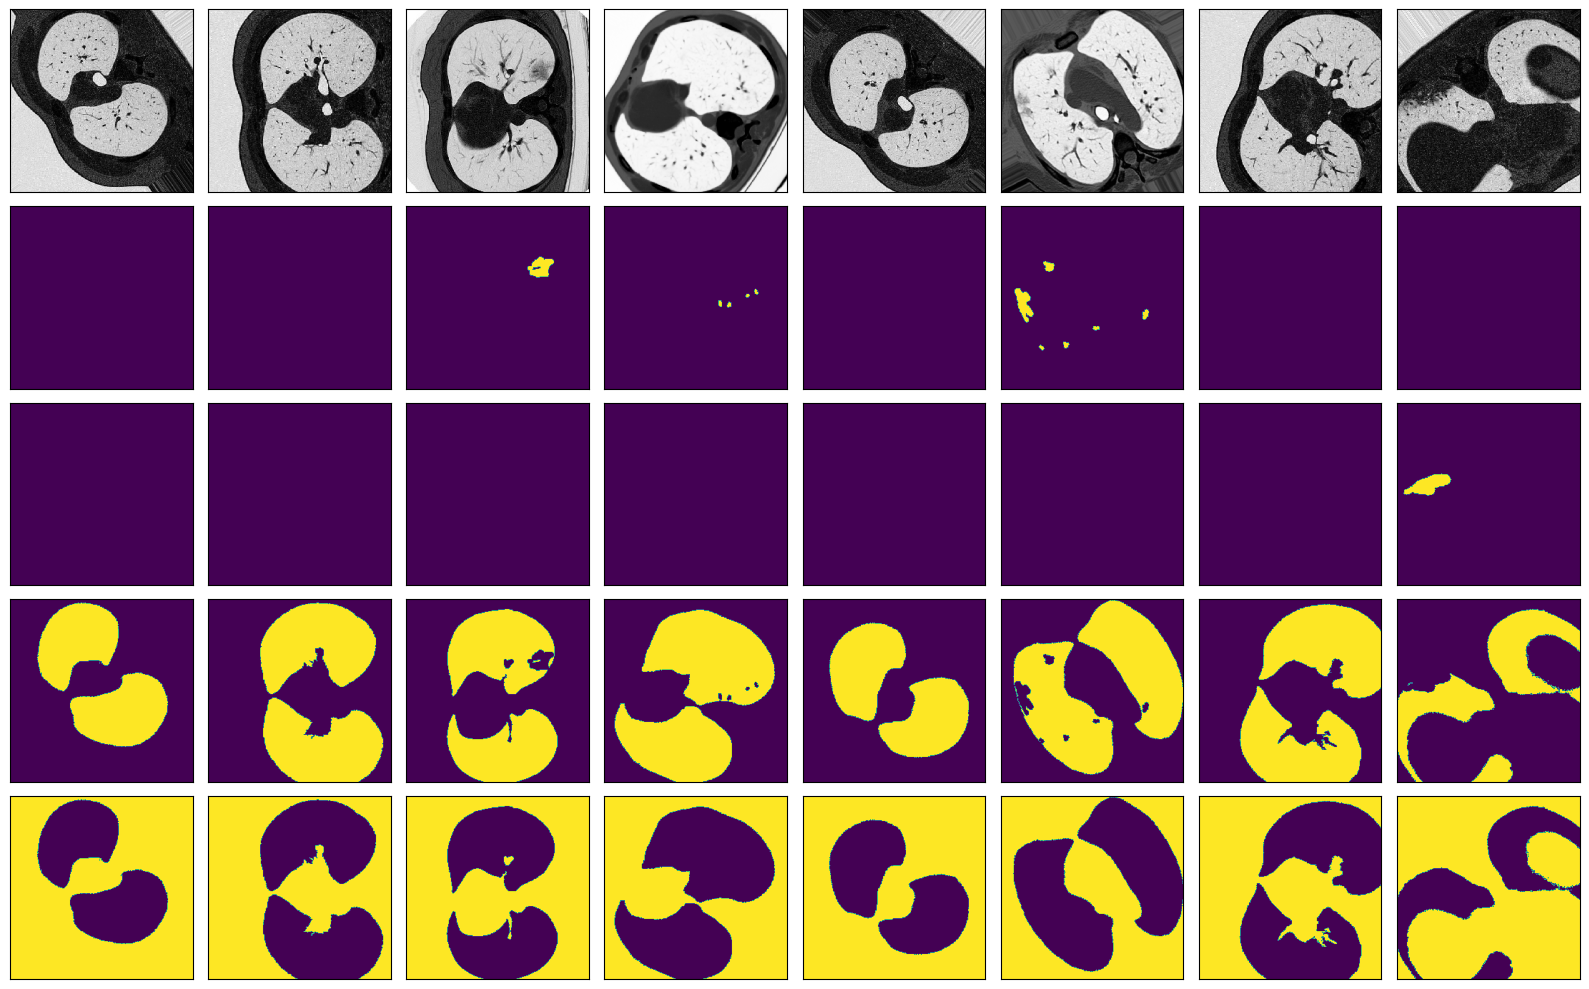

In [176]:
visualize(train_data[0].permute(0, 2, 3, 1), mask_hot_encoded)

In [177]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())

        return accuracy

In [178]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)

            else:
                intersect = (
                    torch.logical_and(true_class, true_label).sum().float().item()
                )

                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)

        return np.nanmean(iou_per_class)

In [179]:
def iou(pred, gt):
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)

    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt

    i = float(np.sum(agg == 2))
    u = float(np.sum(agg > 0))

    if u == 0:
        result = 1
    else:
        result = i / u

    return result

In [180]:
class SegmentationModel(nn.Module):
    def __init__(self, num_classes=4):
        super(SegmentationModel, self).__init__()
        self.backbone = smp.Unet(
            encoder_name="efficientnet-b3",
            encoder_weights="imagenet",
            in_channels=1,
            classes=num_classes,
        )

        self.fpn = smp.FPN(
            encoder_name="efficientnet-b3",
            encoder_weights=None,
            in_channels=1,
            classes=num_classes,
        )

        self.fusion = nn.Conv2d(num_classes * 2, num_classes, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(0.5)
        self.final_activation = nn.LogSoftmax(dim=1)

    def forward(self, x):
        unet_features = self.backbone(x)
        fpn_features = self.fpn(x)

        fused = torch.cat([unet_features, fpn_features], dim=1)
        fused = self.dropout(fused)
        output = self.fusion(fused)
        return self.final_activation(output)

In [181]:
model = SegmentationModel(num_classes=4).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/carlos/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:03<00:00, 15.4MB/s]


In [182]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [183]:
def fit(
    epochs,
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    patch=False,
):
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()

    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        model.train()

        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            output = model(image)

            loss = criterion(output, mask)
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0

            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)

                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)

                    loss = criterion(output, mask)
                    test_loss += loss.item()

            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            if min_loss > (test_loss / len(val_loader)):
                print(
                    "Loss Decreasing.. {:.3f} >> {:.3f} ".format(
                        min_loss, (test_loss / len(val_loader))
                    )
                )
                min_loss = test_loss / len(val_loader)
                decrease += 1
                if decrease % 5 == 0:
                    print("saving model...")
                    torch.save(
                        model,
                        "Unet_efficientnet_b2_mIoU-{:.3f}.pt".format(
                            val_iou_score / len(val_loader)
                        ),
                    )

            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = test_loss / len(val_loader)
                print(f"Loss Not Decrease for {not_improve} time")
                if not_improve == 7:
                    print("Loss not decrease for 7 times, Stop Training")
                    break

            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print(
                "Epoch:{}/{}..".format(e + 1, epochs),
                "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
                "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
                "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
                "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
                "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
                "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
                "Time: {:.2f}m".format((time.time() - since) / 60),
            )

    history = {
        "train_loss": train_losses,
        "val_loss": test_losses,
        "train_miou": train_iou,
        "val_miou": val_iou,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "lrs": lrs,
    }
    print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
    return history

In [184]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

sched = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_dataloader)
)

In [185]:
history = fit(
    epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched
)

  0%|          | 0/38 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:05<00:00,  5.13s/it]


Loss Decreasing.. inf >> 1.047 
Epoch:1/10.. Train Loss: 1.648.. Val Loss: 1.047.. Train mIoU:0.177.. Val mIoU: 0.207.. Train Acc:0.507.. Val Acc:0.738.. Time: 10.51m


100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Loss Decreasing.. 1.047 >> 0.569 
Epoch:2/10.. Train Loss: 0.399.. Val Loss: 0.569.. Train mIoU:0.384.. Val mIoU: 0.394.. Train Acc:0.873.. Val Acc:0.886.. Time: 10.29m


100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


Loss Decreasing.. 0.569 >> 0.486 
Epoch:3/10.. Train Loss: 0.179.. Val Loss: 0.486.. Train mIoU:0.472.. Val mIoU: 0.418.. Train Acc:0.944.. Val Acc:0.908.. Time: 10.32m


100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


Loss Not Decrease for 1 time
Epoch:4/10.. Train Loss: 0.132.. Val Loss: 0.598.. Train mIoU:0.500.. Val mIoU: 0.413.. Train Acc:0.955.. Val Acc:0.898.. Time: 10.30m


100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


Loss Not Decrease for 2 time
Epoch:5/10.. Train Loss: 0.121.. Val Loss: 0.695.. Train mIoU:0.512.. Val mIoU: 0.390.. Train Acc:0.961.. Val Acc:0.875.. Time: 10.25m


100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


Loss Decreasing.. 0.695 >> 0.535 
saving model...
Epoch:6/10.. Train Loss: 0.122.. Val Loss: 0.535.. Train mIoU:0.506.. Val mIoU: 0.422.. Train Acc:0.955.. Val Acc:0.900.. Time: 10.21m


100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


Loss Decreasing.. 0.535 >> 0.505 
Epoch:7/10.. Train Loss: 0.108.. Val Loss: 0.505.. Train mIoU:0.527.. Val mIoU: 0.425.. Train Acc:0.961.. Val Acc:0.906.. Time: 10.19m


100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


Loss Not Decrease for 3 time
Epoch:8/10.. Train Loss: 0.107.. Val Loss: 0.532.. Train mIoU:0.527.. Val mIoU: 0.426.. Train Acc:0.959.. Val Acc:0.905.. Time: 10.20m


100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


Loss Decreasing.. 0.532 >> 0.437 
Epoch:9/10.. Train Loss: 0.099.. Val Loss: 0.437.. Train mIoU:0.533.. Val mIoU: 0.425.. Train Acc:0.963.. Val Acc:0.909.. Time: 10.07m


100%|██████████| 1/1 [00:04<00:00,  4.94s/it]

Loss Decreasing.. 0.437 >> 0.368 
Epoch:10/10.. Train Loss: 0.103.. Val Loss: 0.368.. Train mIoU:0.537.. Val mIoU: 0.423.. Train Acc:0.961.. Val Acc:0.911.. Time: 10.09m
Total time: 102.42 m


In [205]:
torch.save(model, "Unet-efficientnet-b2.pt")

In [206]:
def plot_loss(history):
    plt.plot(history["val_loss"], label="Validation loss", marker="o")
    plt.plot(history["train_loss"], label="Training loss", marker="o")

    plt.title("Loss per epoch")
    plt.xlabel("Epoch")
    plt.legend(), plt.grid()
    plt.show()

In [207]:
def plot_score(history):
    plt.plot(history["train_miou"], label="Training mIoU", marker="*")
    plt.plot(history["val_miou"], label="Validation mIoU", marker="*")

    plt.title("Scores per epoch")
    plt.xlabel("Epoch")
    plt.legend(), plt.grid()
    plt.show()

In [208]:
def plot_acc(history):
    plt.plot(history["train_acc"], label="train_accuracy", marker="*")
    plt.plot(history["val_acc"], label="val_accuracy", marker="*")

    plt.title("Accuracy per epoch")
    plt.ylabel("Accuracy")
    plt.xlabel("epoch")

    plt.legend(), plt.grid()
    plt.show()

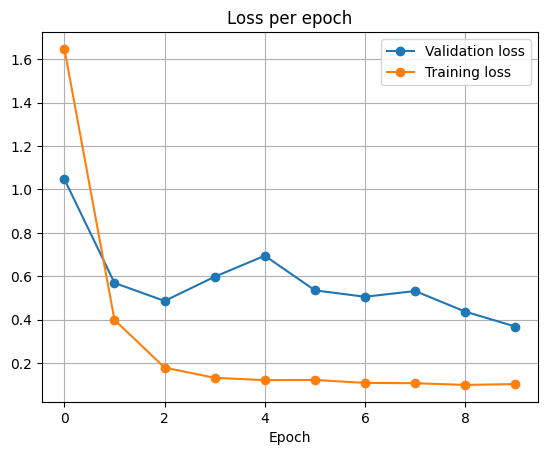

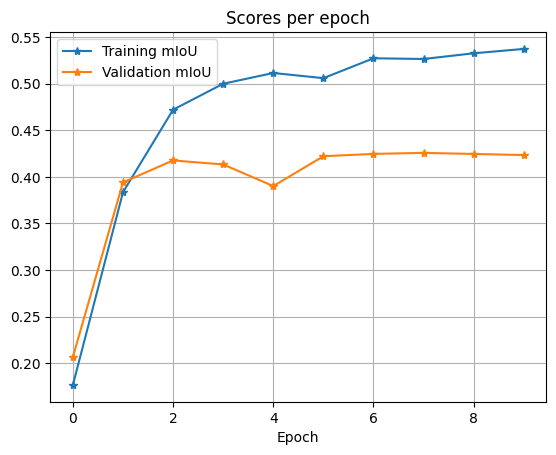

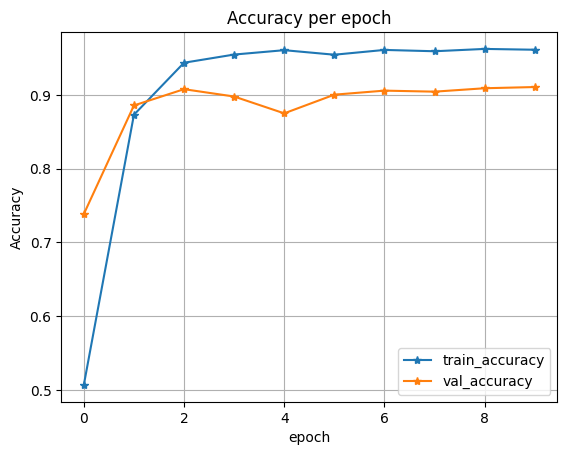

In [209]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Evaluation


In [210]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    model.eval()

    model.to(device)
    image = image.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        output = model(image)
        a, b, c, d = output.shape
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, output.permute(0, 2, 3, 1)

In [211]:
def predict_image_mask_pixel(
    model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
):
    model.eval()
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)

    return masked, acc

In [212]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []

    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)

    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

In [213]:
image, mask = next(iter(val_dataloader))
pred_mask, score, output = predict_image_mask_miou(model, image, mask)
semantic_map = mask_to_onehot(torch.unsqueeze(mask, -1).numpy(), palette)

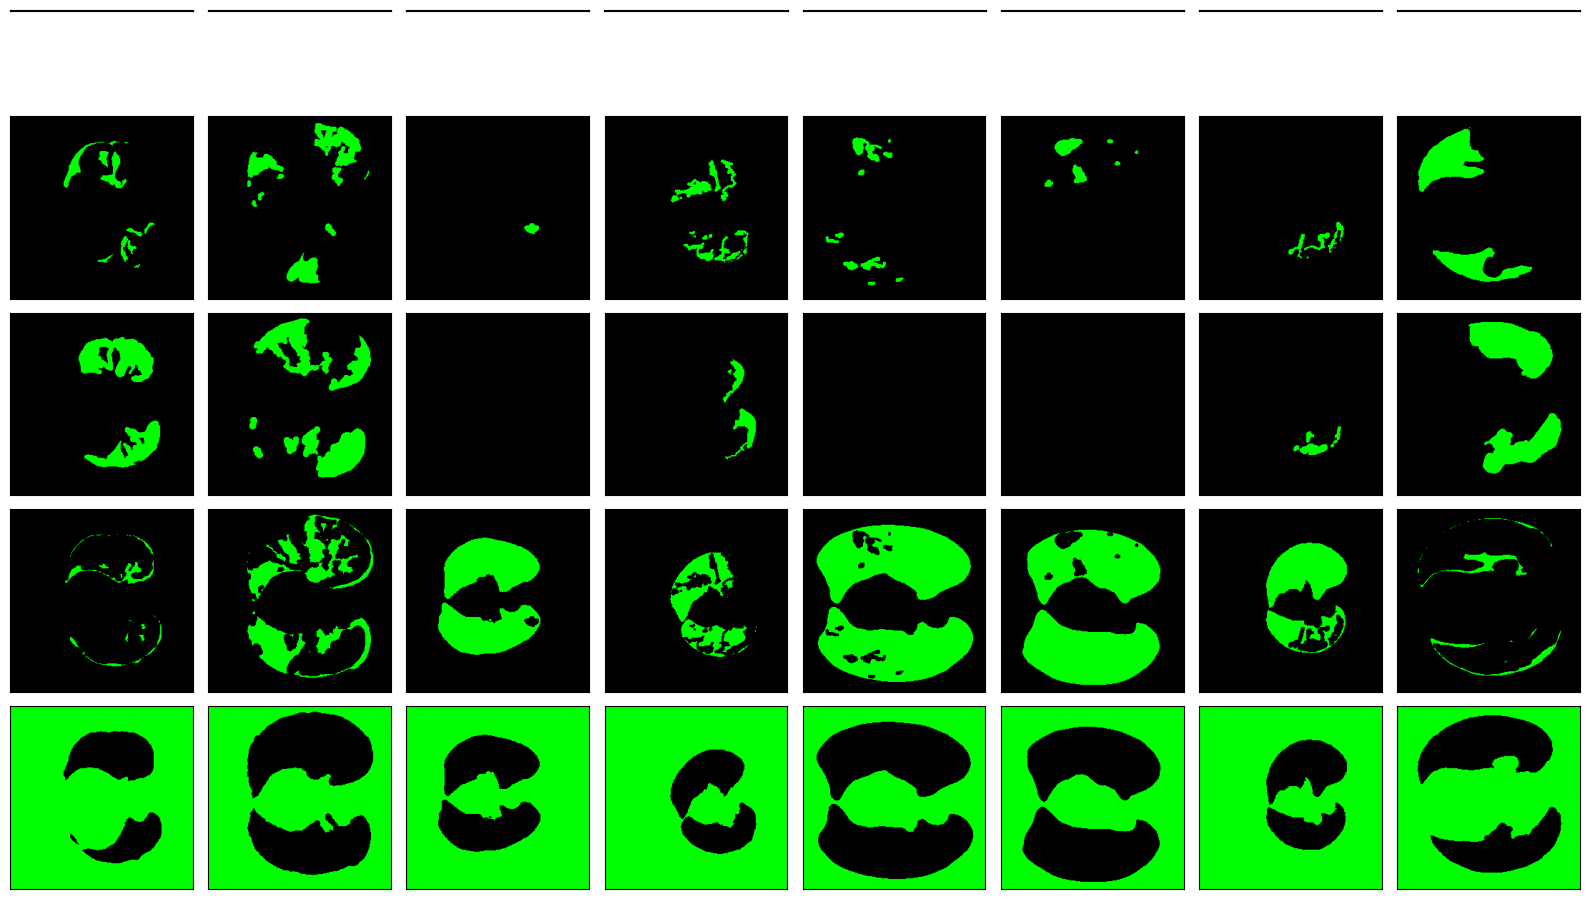

In [214]:
visualize(image, semantic_map, pred_batch=output)

In [215]:
def miou_score(model, test_set):
    score_iou = []
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        pred_mask, score, output = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)

    return score_iou

In [216]:
mob_miou = miou_score(model, val_dataloader)
print(f"Mob_miou: {mob_miou}")

100%|██████████| 1/1 [00:04<00:00,  4.27s/it]

Mob_miou: [0.42343909351663767]


In [217]:
del train_images
del train_masks

NameError: name 'train_images' is not defined

In [218]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.eval()

    model.to(device)
    image = image.to(device)

    with torch.no_grad():
        output = model(torch.unsqueeze(image, 1))
        output = nn.Softmax(dim=1)(output)

    return output.permute(0, 2, 3, 1)

In [219]:
image_batch = np.stack(
    [val_augs(image=img)["image"] for img in test_images_medseg], axis=0
)

print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)

torch.Size([10, 256, 256, 1])
(256, 256, 1)


In [220]:
output = np.zeros((10, 256, 256, 4))
for i in range(10):
    output[i] = test_predict(model, image_batch[i])

print(output.shape)

(10, 256, 256, 4)


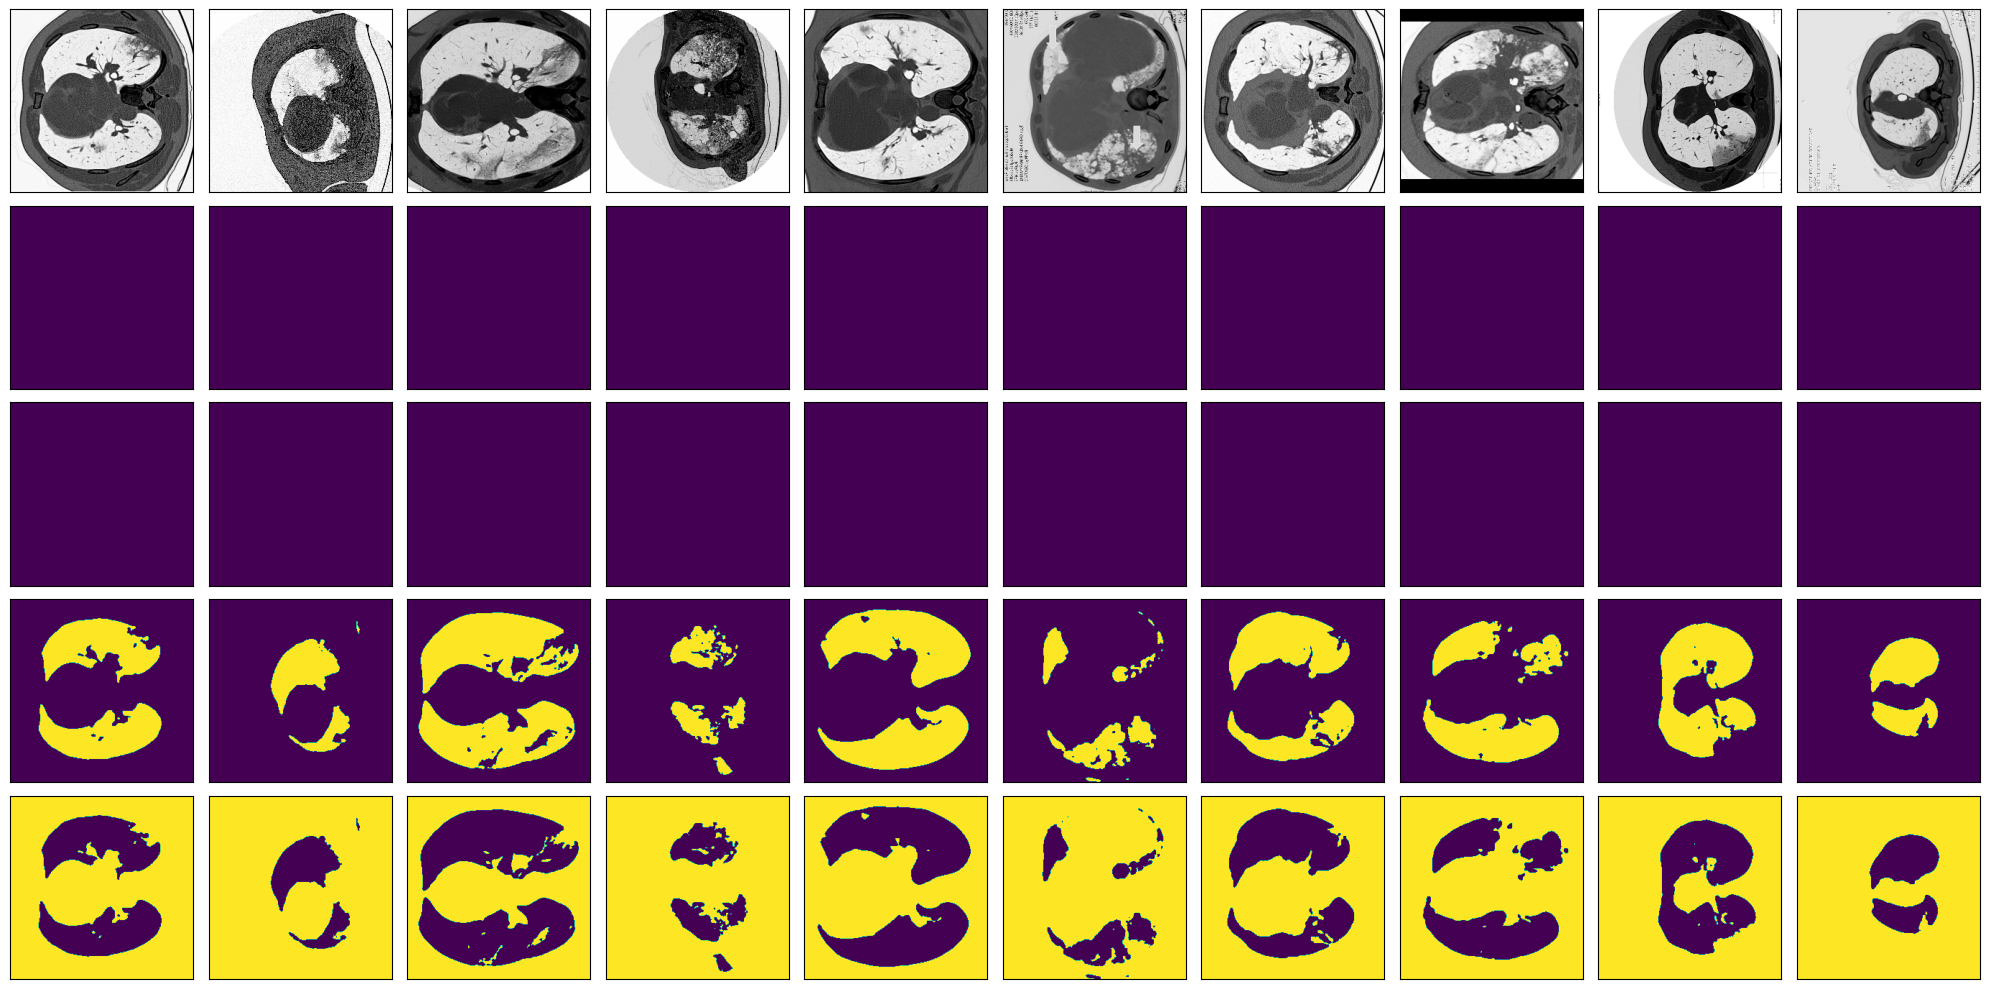

In [221]:
test_masks_prediction = output > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

In [222]:
import scipy

test_masks_prediction_original_size = scipy.ndimage.zoom(
    test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0
)

test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [223]:
import pandas as pd

pd.DataFrame(
    data=np.stack(
        (
            np.arange(len(test_masks_prediction_original_size.ravel())),
            test_masks_prediction_original_size.ravel().astype(int),
        ),
        axis=-1,
    ),
    columns=["Id", "Predicted"],
).set_index("Id").to_csv("sub.csv")

### Referencias:

- Igor.Slinko. (2020). COVID-19 CT Images Segmentation . Kaggle. https://kaggle.com/competitions/covid-segmentation
- Works Cited“Exploración Por Tomografía Computarizada - Mayo Clinic.” Mayoclinic.org, 2022, www.mayoclinic.org/es/tests-procedures/ct-scan/about/pac-20393675#:~:text=Una%20tomograf%C3%ADa%20computarizada%20se%20puede. Accessed 12 Sept. 2024.
- NYSORA. “Estudio de Caso: Tenosinovitis de de Quervain.” NYSORA, 18 Apr. 2024, www.nysora.com/es/noticias/Caracter%C3%ADsticas-ecogr%C3%A1ficas-del-signo-de-consolidaci%C3%B3n-pulmonar-y-hepatizaci%C3%B3n./.
- “Qué Significan Las Áreas Grises (OVE) En Una Radiografía O Tomografía.” Www.medicalnewstoday.com, 28 Jan. 2022, www.medicalnewstoday.com/articles/es/opacidad-de-vidrio-molido.